In [16]:
# testing hysteresis parameter calculation? 
import numpy as np
import scipy.integrate as spi
from scipy.optimize import curve_fit
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import matplotlib.collections as mcoll
import matplotlib.path as mpath

storm_directory = 'C:/Users/nicol/Documents/GitHub/La_Jara/Hysteresis/All_Summer_Storms'
storms = {}
for filename in os.listdir(storm_directory):
    # check if the file is a CSV file
    if filename.endswith('.csv'):
        file_path = os.path.join(storm_directory, filename) # construct the full file path
        df = pd.read_csv(file_path)                         # read the CSV file into a data frame
        df = df.dropna(subset=['Date_Time'])                # drop rows where 'Date/Time' is NaN  
        df['Date_Time'] = pd.to_datetime(df['Date_Time'])   # convert to datetime format
        df = df.set_index('Date_Time')                      # set date time as the index 
        df = df.dropna(how='all', axis=1)                   # drop columns where all values are NaN
        key = filename[:-4]                                 # remove the '.csv' from the filename to use as the dictionary key
        storms[key] = df                                    # store the data frame in the dictionary

## STORM 1 AS EXAMPLE ## 
SSC = storms['st1_down']['SS (uL/L)']
depth = storms['st1_down']['depth']
time = storms['st1_down'].index

In [2]:
storms['st1_down']

,SS (uL/L),SRP (mg/L),TP (mg/L),DOC (mg/L),POC (mg/L),PP (mg/L),fDOM,Turbidity,P2C,P3C,P2C_depth,P3C_depth,depth
Date_Time,,,,,,,,,,,,,
2021-07-23 15:50:00,339.78248,0.062,0.360,9.18,51.660,1.19,249.27,91.20,2723.170033,2724.256253,16.103333,26.825267,26.825267
2021-07-23 16:09:00,457.12000,0.088,0.445,12.63,50.228,1.63,236.32,256.63,2723.179359,2724.262816,17.035940,27.481640,27.481640
2021-07-23 16:40:00,152.79000,0.088,0.248,13.39,14.502,0.77,377.89,76.14,2723.185071,2724.266408,17.607100,27.840833,27.840833
2021-07-23 16:55:00,168.45000,0.083,0.214,13.00,11.681,0.50,413.81,100.94,2723.183121,2724.265220,17.412100,27.722033,27.722033
2021-07-23 19:19:00,43.15000,0.053,0.097,12.87,6.411,0.10,515.85,22.13,2723.154470,2724.243058,14.546960,25.505847,25.505847
2021-07-23 21:02:00,17.70000,0.047,0.077,11.55,4.805,0.07,506.48,11.14,2723.145268,2724.232969,13.626833,24.496887,24.496887


In [17]:
def log_fit(Q, a, b):
    return a * np.log(Q) + b

def exp_fit(Q, a, b):
    return a * np.exp(b * Q)

def compute_r2(y_obs, y_pred):
    ss_res = np.sum((y_obs - y_pred) ** 2)  # Residual sum of squares
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

peak_idx = np.argmax(depth)  # index of max discharge
rising_mask = np.arange(len(depth)) <= peak_idx # rising limb includes everything up to and including the peak
falling_mask = ~rising_mask # falling limb includes everything after the peak

depth_rising, SSC_rising, time_rising = depth[rising_mask], SSC[rising_mask], time[rising_mask]
depth_falling, SSC_falling, time_falling = depth[falling_mask], SSC[falling_mask], time[falling_mask]

In [18]:
# fit regression models
# rising limb
rising_param, _ = curve_fit(log_fit, depth_rising, SSC_rising, maxfev=10000)
SSC_rising_fit = log_fit(depth_rising, *rising_param)
r2_rising = compute_r2(SSC_rising, SSC_rising_fit)
# falling limb
falling_param, _ = curve_fit(exp_fit, depth_falling, SSC_falling, maxfev=10000)
SSC_falling_fit = exp_fit(depth_falling, *falling_param)
r2_falling = compute_r2(SSC_falling, SSC_falling_fit)

print(f"SSC R² for rising limb: {r2_rising:.4f}")
print(f"SSC R² for falling limb: {r2_falling:.4f}")

SSC R² for rising limb: 0.2156
SSC R² for falling limb: 0.9985


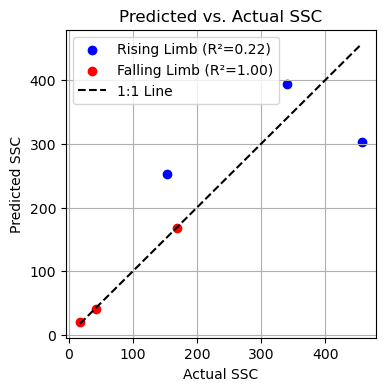

In [19]:
# plot actual vs. predicted SSC for rising and falling limbs
plt.figure(figsize=(4, 4))
plt.scatter(SSC_rising, SSC_rising_fit, color='blue', label=f'Rising Limb (R²={r2_rising:.2f})') # rising limb
plt.scatter(SSC_falling, SSC_falling_fit, color='red', label=f'Falling Limb (R²={r2_falling:.2f})') # falling limb
# 1:1 line (perfect fit)
min_val = min(min(SSC_rising), min(SSC_falling))
max_val = max(max(SSC_rising), max(SSC_falling))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="1:1 Line")
plt.xlabel("Actual SSC")
plt.ylabel("Predicted SSC")
plt.title("Predicted vs. Actual SSC")
plt.legend()
plt.grid(True)
plt.show()


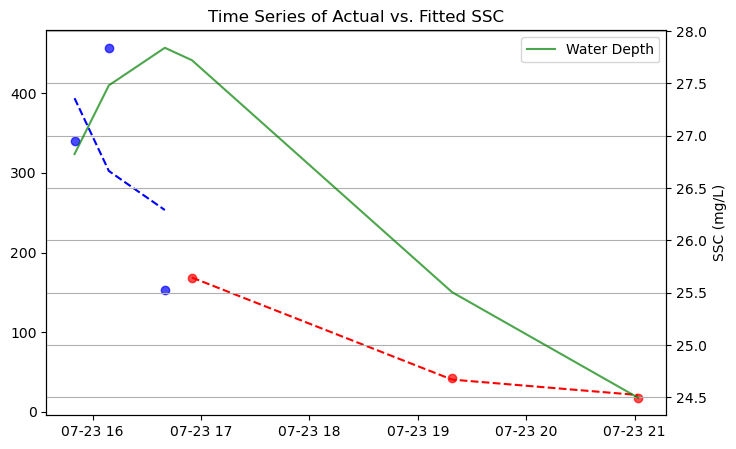

In [22]:
import matplotlib.pyplot as plt

# Assuming 'time_rising' and 'time_falling' contain timestamps or sequential indices
plt.figure(figsize=(8, 5))

# Plot actual SSC
plt.scatter(time_rising, SSC_rising, color='blue', label='Actual Rising SSC', alpha=0.7)
plt.scatter(time_falling, SSC_falling, color='red', label='Actual Falling SSC', alpha=0.7)

# Plot fitted SSC
plt.plot(time_rising, SSC_rising_fit, color='blue', linestyle='--', label='Fitted Rising SSC')
plt.plot(time_falling, SSC_falling_fit, color='red', linestyle='--', label='Fitted Falling SSC')

# Plot water depth in another axis
ax2 = plt.gca().twinx()
plt.plot(time, depth, color='green', label='Water Depth', alpha=0.7)

# Labels and legend
plt.xlabel("Time")
plt.ylabel("SSC (mg/L)")
plt.title("Time Series of Actual vs. Fitted SSC")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# plot time series of depth and ssc 
